# Use case 3 - Flooding in Zuid-Holland

## Introduction 

The focus of this use case is adaptation under uncertainty in interdependent Critical Infrastructure. This use case is most relevant for electricity distribution network operators.

Using pluvial flood data for South Holland, in the Netherlands, we estimate the disruptions on medium-low voltage substations, considering a set number of repair crews to carry out repairs on broken down substations. We availability of the road network is used to determine whether a substation can be reached. 

In [ ]:
# HIDE CODE

import sys
import time
sys.path.append(str(Path.cwd().parent))
import geopandas as gpd
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from pathlib import Path
from rasterio.plot import plotting_extent

from src.damage_recovery import (
    default_damage_ratio_function,
    default_repair_time_function,
    vectorized_damage_ratio_solver,
    default_fragility_function)
from src.adaptation import simulate_asset_damage_recovery_access_breakdown_ema
from config import get_config, get_development_config, setup_dev_directories, get_simulation_params
from src.simulation import simulate_asset_damage_recovery_access_breakdown 
from src.data_loader import load_hazard_maps, load_electricity_assets
from src.caching import load_simulation_caches
from pathlib import Path
from src.impacts import create_voronoi_for_asset_type, prepare_population_impact_data, prepare_land_use_impact_data, update_voll_rates, prepare_land_use_impact_data
import pickle
from src.visualization import *
from ema_workbench import Model, RealParameter, IntegerParameter, Constant, TimeSeriesOutcome, SequentialEvaluator, Samplers, ema_logging, Policy

```{note}
In this Use Case the Hazard, exposure, population, and land use data cover a large area leading to very heavy files. Therefore, in this notebook a sample of the data is provided instead.
```

## Directory structure 


In [2]:
# Set up configuration
config = get_development_config() #get_config() gets parameters directly from config.py in root, development config uses sample data
setup_dev_directories(config, remove_cache=True)
HAZARD_EXTRACTION_METHOD = config['analysis_config']['hazard_extraction_method']

# Configure simulation parameters from config
simulation_params = get_simulation_params(config) 
accessibility_model = None
simulation_params['accessibility_model'] = accessibility_model

print(f"\nSimulation configuration:")
for key, value in simulation_params.items():
    if key != 'config':  # Don't print the entire config
        print(f"  {key}: {value}")

print(f"\nDirectory structure:")
print(f"  Interim: {config['interim_dir']}")
print(f"  Output: {config['output_dir']}")
print(f"  Cache will be organized by hazard directory: {Path(config['hazard_dir']).name}")

config['simulation_config']['major_timestep'] = 24
config['simulation_config']['verbose'] = False
max_days = None

caches = load_simulation_caches(config['interim_dir'], config['hazard_dir'])
print(f"Loaded caches: {[k for k in caches.keys() if caches[k] is not None]}")

root_dir = Path(config['root_dir'])
study_area_path = root_dir / 'data' / 'utilities' / 'stedin_area.geojson'
land_use_path = root_dir / 'data' / 'land_use' / 'CBS_Publicatiebestand_BBG2017_v1_sample.gpkg'
population_data_path = root_dir / "data" / "population" / "cbs_vk100_2024_v1_sample.gpkg"

print(f"WARNING! Values of lost load should be calculated with country-wide VOLL rates, not sample data!")

# Cache path for asset_to_lu (the complete pre-computed lookup)
asset_to_lu_cache_path = config['interim_dir'] / f"{land_use_path.stem}_asset_to_lu.pkl"

Created directories: c:\repos\UC3\data\interim\interim_test_hazard_timesteps, c:\repos\UC3\data\output\output_test_hazard_timesteps

Simulation configuration:
  flood_threshold: 0.2
  number_repair_crews: 5
  repair_crew_assignment_method: islands
  verbose: True
  recovery_parameters: {'repair_time_coefficients': [702.72, 3.14, 1.9891], 'damage_ratio_coefficients': (0.0468, 0.0077), 'damage_threshold': 0.01, 'repair_threshold': 2.0}
  accessibility_model: None

Directory structure:
  Interim: c:\repos\UC3\data\interim\interim_test_hazard_timesteps
  Output: c:\repos\UC3\data\output\output_test_hazard_timesteps
  Cache will be organized by hazard directory: test_hazard_timesteps
Loading simulation caches...
No accessibility cache found at c:\repos\UC3\data\interim\interim_test_hazard_timesteps\accessibility_cache_test_hazard_timesteps.pkl
No hazard extraction cache found at c:\repos\UC3\data\interim\interim_test_hazard_timesteps\hazard_extraction_cache_test_hazard_timesteps.pkl
No isla

## Hazard characterisation 

**Pluvial flooding**

The flood considered in this use case is produced by excess rainfall. 
To produce this data, the assumption of 200 mm of rainfall on previously wet soil over the whole province of South Holland, the Netherlands was considered. 

The data consists of time explicity flooding depth maps at a daily timestep. The aggregated flood maps for this model can be found in the Open Data Portal of Zuid Holland: https://opendata.zuid-holland.nl/geonetwork/srv/api/records/6cb97102-f3b3-421e-a37e-c90615118e6d

While this case considers a single hazard type (pluvial flooding), it looks into consecutive days of flooding with the cascading effects of disrupted roads on the electricity network repairs.


Found 10 hazard map files


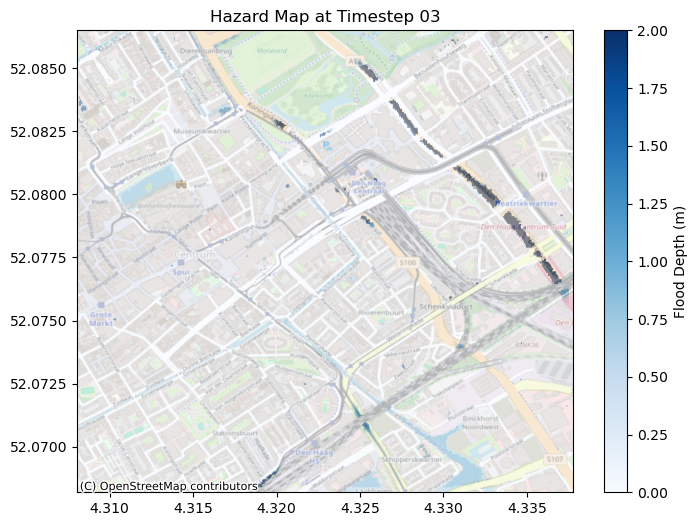

In [3]:
hazard_maps = load_hazard_maps(config['hazard_dir'], max_days=None)  
hazard_map_03 = hazard_maps[3]
with rasterio.open(hazard_map_03) as src:
    hazard_data_03 = src.read(1)
    hazard_transform_03 = src.transform
    crs = src.crs

fig, ax = plt.subplots(figsize=(8, 6))
extent = plotting_extent(hazard_data_03, hazard_transform_03)
im = ax.imshow(hazard_data_03, cmap='Blues', vmax=2, extent=extent, origin='upper')
ax.set_title("Hazard Map at Timestep 03")
fig.colorbar(im, ax=ax, label="Flood Depth (m)")

# Set axis to Web Mercator for contextily
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_aspect('auto')
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik, zoom=15, alpha=0.5)
plt.show()

## Exposure Assessment

The electricity substation data is provided by Stedin, the local DSO, openly. 
The street data used is retrieved from OpenStreetMap.


Found 1 electricity station files matching types ['msls']
All .shp files in directory: ['ls_stations_test_samples.shp', 'msls_stations_test_samples.shp', 'ms_stations_test_samples.shp']
Files with 'station': ['ls_stations_test_samples.shp', 'msls_stations_test_samples.shp', 'ms_stations_test_samples.shp']
Final matched files: ['msls_stations_test_samples.shp']
Loading electricity assets from msls_stations_test_samples.shp
Loaded 245 msls assets
Combined total: 245 electricity assets
Asset types: {'msls': 245}


C:\Users\peregrin\AppData\Local\Temp\ipykernel_29288\2282920993.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_assets.centroid.to_crs(epsg=4326).plot(ax=ax, color='green', markersize=20)


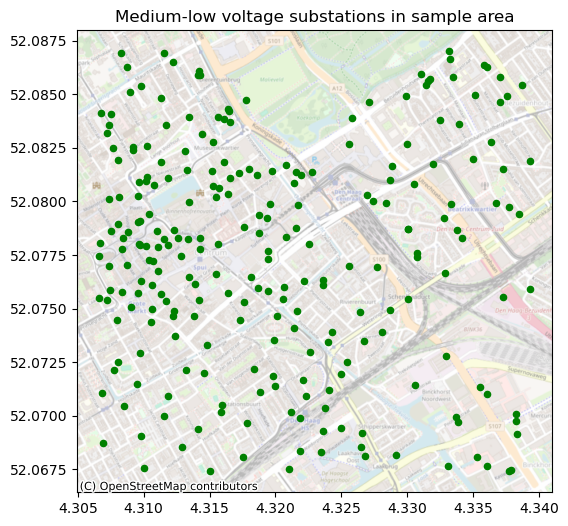

In [4]:
gdf_assets = load_electricity_assets(config['electricity_dir'], asset_types=['msls'])
fig, ax = plt.subplots(figsize=(8, 6))
gdf_assets.centroid.to_crs(epsg=4326).plot(ax=ax, color='green', markersize=20)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik, zoom=15, alpha=0.5)
plt.title("Medium-low voltage substations in sample area")
plt.show()

## Vulnerability Assessment 

We estimate the damage to substations by intersecting the footprints of the substations with flooding depth data and taking the maximum value. 

This value is then related to substation damage using a linearized depth-damage (vulnerability) curve (FEMA, 2003; Sánchez-Muñoz et al., 2020). Substation damage is expressed as a damage ratio between 0 (undamaged) and 1 (fully damaged). Finally, the damage ratio is used to estimate the repair time in hours through a repair time function ([Movahednia et al., 2022](https://doi.org/10.1109/TII.2021.3100079) and [Sánchez-Muñoz et al., 2020](https://doi.org/10.3390/su12041527)).

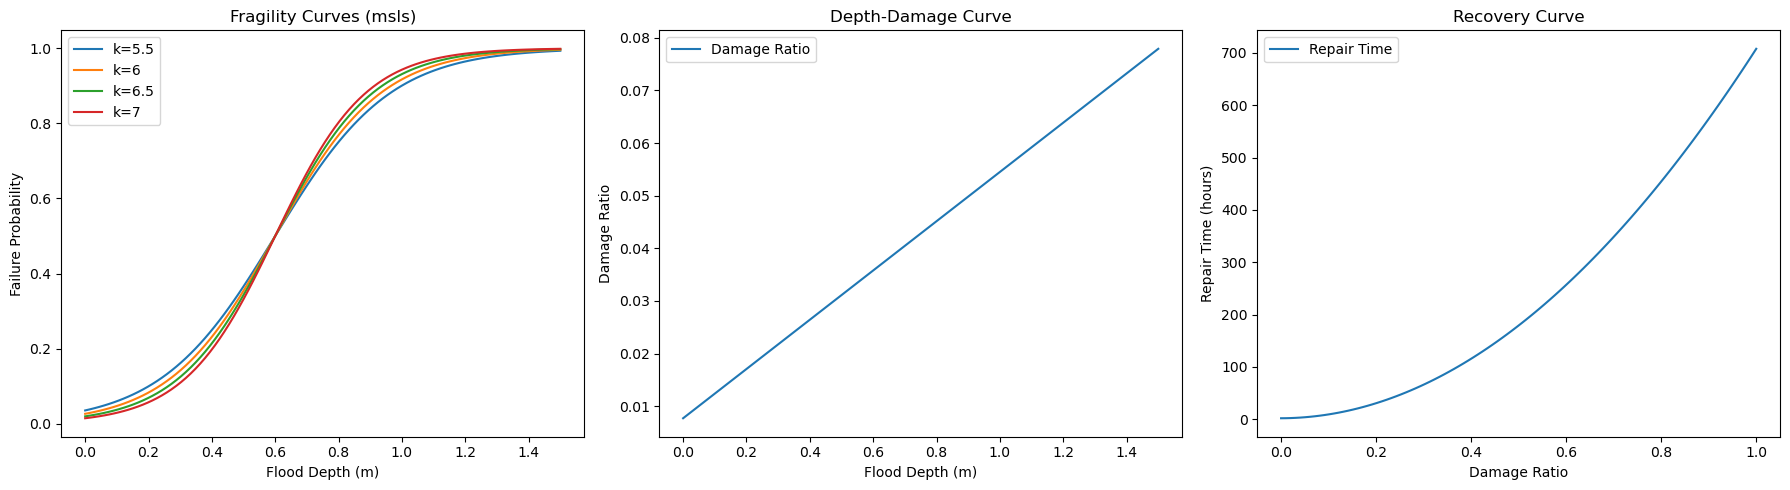

In [5]:
# Example coefficients for curves
damage_coeffs = simulation_params['recovery_parameters']['damage_ratio_coefficients']  # m, n for damage ratio
repair_coeffs = simulation_params['recovery_parameters']['repair_time_coefficients']  # a, b, c for repair time

hazard_depths = np.linspace(0, 1.5, 100)
damage_ratios = default_damage_ratio_function(hazard_depths, damage_coeffs)
damage_ratios = np.clip(damage_ratios, 0, 1)  # Ensure damage ratio does not exceed 1

# Recovery functions in range [0, 1]
damage_ratios_recovery = np.linspace(0, 1, 100)
repair_times = default_repair_time_function(damage_ratios_recovery, repair_coeffs)

# Fragility curves for different positive slopes
slopes = [5.5, 6, 6.5, 7]
fragility_curves = {
    k: 1 / (1 + np.exp(-k * (hazard_depths - 0.6)))
    for k in slopes
}

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Fragility curves with multiple slopes
for k, curve in fragility_curves.items():
    axs[0].plot(hazard_depths, curve, label=f'k={k}')
axs[0].set_title('Fragility Curves (msls)')
axs[0].set_xlabel('Flood Depth (m)')
axs[0].set_ylabel('Failure Probability')
axs[0].legend()

# 2. Depth-Damage curve
axs[1].plot(hazard_depths, damage_ratios, label='Damage Ratio')
axs[1].set_title('Depth-Damage Curve')
axs[1].set_xlabel('Flood Depth (m)')
axs[1].set_ylabel('Damage Ratio')
axs[1].legend()

# 3. Recovery curve in [0,1]
axs[2].plot(damage_ratios_recovery, repair_times, label='Repair Time')
axs[2].set_title('Recovery Curve')
axs[2].set_xlabel('Damage Ratio')
axs[2].set_ylabel('Repair Time (hours)')
axs[2].legend()

plt.tight_layout()
plt.show()

## Risk Assessment 

The time explicit breakdown and recovery simulation is done iteratively to explore the uncertainty space, with all the deterministic results (e.g. flood overlays, road isolations, etc) being computed once, and catched for future runs. 

### A single simulation is not enough

The results from a single simulation give some indication of the stations that get flooded, the duration of the flood, and the extent of the damage. Here we set the slope of the fragility curve at 6.0, and assume there are 5 repair crews available for the area

In [6]:
all_results, final_state, cache_updated = simulate_asset_damage_recovery_access_breakdown(
    gdf_assets,
    hazard_maps,
    number_repair_crews = 5,
    repair_crew_assignment_method = simulation_params['repair_crew_assignment_method'],
    flood_threshold = simulation_params['flood_threshold'],
    recovery_parameters = simulation_params['recovery_parameters'],
    root_dir = config['root_dir'],
    verbose = False,
    timestep_output=True,
    execution_id = "test_run_breakdown",
    config=config,
    major_timestep=config['simulation_config']['major_timestep'],
    accessibility_cache=caches.get('accessibility_cache', None),
    hazard_extraction_cache=caches.get('hazard_extraction_cache', None),
    overlap_cache=caches.get('overlap_cache', None),
    island_cache=caches.get('island_cache', None), 
    fragility_param_k=6.0
)
print(f"\nSimulation completed. Cache updated")

Identified 16 boundary assets out of 245 total assets.
Extracting hazard values using method: max
Saved hazard extraction cache: 1 entries to c:\repos\UC3\data\interim\interim_test_hazard_timesteps\hazard_extraction_cache_test_hazard_timesteps.pkl
Cached hazard extraction results for map 0 from GHG_timesteps_test0.tif
Cache miss for island_assignment_EV0_ma_0.2_n245_ffb9075134a2efe7ad5cdcebb95eef31, computing islands on the fly...
Loading hazard graph from c:\repos\UC3\data\test_samples\static\output_graph\base_graph_hazard_editted.p
Saved island cache: 1 entries to c:\repos\UC3\data\interim\interim_test_hazard_timesteps\island_cache_test_hazard_timesteps.pkl
Successfully computed and cached islands for island_assignment_EV0_ma_0.2_n245_ffb9075134a2efe7ad5cdcebb95eef31
Extracting hazard values using method: max
Saved hazard extraction cache: 2 entries to c:\repos\UC3\data\interim\interim_test_hazard_timesteps\hazard_extraction_cache_test_hazard_timesteps.pkl
Cached hazard extraction re

In [7]:
results_df_x=pd.DataFrame(all_results[0][1])
print_simulation_summary(results_df_x, gdf_assets, config)

SIMULATION RESULTS SUMMARY
Total assets: 245
Simulation duration: 240 hours (10 days)
Final operational rate: 100.0%
Peak damaged assets: 6
Peak flooded assets: 6
Total crew assignments: 16

RECOVERY TIMELINE (Daily Summary)
Day 0: 100.0% operational, 0 flooded, 0 unreachable, 0 damaged.
Day 1: 98.8% operational, 5 flooded, 0 unreachable, 5 damaged.
Day 2: 98.8% operational, 6 flooded, 0 unreachable, 6 damaged.
Day 3: 98.8% operational, 5 flooded, 0 unreachable, 5 damaged.
Day 4: 99.6% operational, 2 flooded, 0 unreachable, 2 damaged.
Day 5: 99.6% operational, 2 flooded, 0 unreachable, 2 damaged.
Day 6: 100.0% operational, 0 flooded, 0 unreachable, 0 damaged.
Day 7: 100.0% operational, 0 flooded, 0 unreachable, 0 damaged.
Day 8: 100.0% operational, 0 flooded, 0 unreachable, 0 damaged.
Day 9: 100.0% operational, 0 flooded, 0 unreachable, 0 damaged.

REPAIR BACKLOG ANALYSIS
Hour | Flooded | Damaged | Crews | Backlog | Effective?
-------------------------------------------------------
 0.

To understand the extent of the impact, it is necessary to map the population and the value of lost load to each substations. In other words, when a substation fails, it is necessary to understand how many people live in the area it services, and the economic activity that takes place in the area. 

For that, population and land-use information can be of use. The Central Bureau voor de Statistiek (CBS) of the Netherlands provides this information - https://www.cbs.nl/en-gb

First, the population data is mapped to service areas:

```{note}
In this notebook, a sample of the data is used. Please note that for monetary impacts to be relevant, the country-scale land-use data should be used; when the country-scale data is used, this computation can take several minutes. 
```

In [8]:
study_area = gpd.read_file(study_area_path, driver='GeoJSON').to_crs("EPSG:28992")

buffer_distance_meters = 1000
population_buffer = study_area.buffer(buffer_distance_meters)
population_buffer.set_crs("EPSG:28992")

# Create Voronoi polygons for service areas
print("Creating Voronoi polygons for service areas...")
voronoi_polygons_by_type = {}
for asset_type in gdf_assets['type'].unique():
    voronoi_gdf = create_voronoi_for_asset_type(
        gdf_assets, 
        asset_type, 
        boundary=study_area.geometry.unary_union
    )
    voronoi_polygons_by_type[asset_type] = voronoi_gdf

# Load and prepare population data
print("Loading population data...")
population_data = gpd.read_file(
    population_data_path,
    driver='GPKG',
    bbox=tuple(voronoi_gdf.total_bounds)
).to_crs("EPSG:28992")

# Filter out zero population and invalid geometries
population_data = population_data[
    (population_data['aantal_inwoners'] > 0) & 
    (~population_data.geometry.isna())
].dropna(subset=['geometry'])

# Clip to study area
population_study_area = gpd.clip(population_data, population_buffer)
population_above_0 = population_study_area[['aantal_inwoners', 'geometry']].set_crs("EPSG:28992")

# Prepare population impact mapping
print("Preparing population impact data...")
asset_population_map = prepare_population_impact_data(
    population_data=population_above_0,
    voronoi_gdf=voronoi_polygons_by_type['msls']
)
print(f"Population data prepared for {len(asset_population_map)} assets")

voronoi_gdf['pop_map'] = [asset_population_map[x] for x in voronoi_gdf['asset_id']]


c:\Users\peregrin\AppData\Local\miniforge3\envs\miraca_template\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(
C:\Users\peregrin\AppData\Local\Temp\ipykernel_29288\3309938487.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary=study_area.geometry.unary_union
c:\Users\peregrin\AppData\Local\miniforge3\envs\miraca_template\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(


Creating Voronoi polygons for service areas...
Loading population data...
Preparing population impact data...
Population assignment: 221/229 polygons with impact values
Total assigned population: 41969
Population data prepared for 229 assets


Then, the same is done for Values of Lost Load per land use:

In [9]:
# Try to load pre-computed asset_to_lu
if asset_to_lu_cache_path.exists():
    print(f"Loading asset_to_lu from cache: {asset_to_lu_cache_path}")
    with open(asset_to_lu_cache_path, 'rb') as f:
        asset_to_lu = pickle.load(f)
    print(f"Loaded asset_to_lu for {len(asset_to_lu)} assets from cache")

    asset_land_use_map = {
        aid: {lu_type: area for lu_type, area, voll_rate in lu_entries}
        for aid, lu_entries in asset_to_lu.items()
    }
    
else:
    print("Computing asset_to_lu from scratch...")
       
    # Load land use data
    land_use_data = gpd.read_file(land_use_path, driver='GPKG')
    
    # Calculate VOLL rates (populates VOLL_PER_SQM)
    consumption_per_sqm, voll_per_sqm = update_voll_rates(land_use_data)
    print(f"VOLL rates calculated for {len(voll_per_sqm)} categories")
    
    # Compute asset-land use intersections (the expensive operation)
    asset_land_use_map = prepare_land_use_impact_data(
        land_use_data, 
        voronoi_gdf=voronoi_polygons_by_type['msls']
    )
    print(f"Computed intersections for {len(asset_land_use_map)} assets")
    
    # Build asset_to_lu with VOLL rates included
    asset_to_lu = {}
    for aid, lu_dict in asset_land_use_map.items():
        asset_to_lu[aid] = [(lu_type, area, voll_per_sqm[lu_type]) 
                             for lu_type, area in lu_dict.items() 
                             if lu_type in voll_per_sqm]
    
    # Cache the complete lookup
    with open(asset_to_lu_cache_path, 'wb') as f:
        pickle.dump(asset_to_lu, f)
    print(f"Saved asset_to_lu to cache: {asset_to_lu_cache_path}")

# Output
print(f"\nasset_to_lu ready with {len(asset_to_lu)} assets")

Computing asset_to_lu from scratch...
Consumption per square meter by land use [MWh/h/m²]:
  commercial: 0.0023797518
  industrial: 0.0066238837
  public_sector: 0.0024542763
  transport: 0.0010109956
  residential: 0.0035054641
  other: 0.0000023999

VOLL per square meter by land use [€/h/m²]:
  commercial: 202.115201
  industrial: 511.113373
  public_sector: 246.235459
  transport: 107.078586
  residential: 121.293896
  other: 0.000002
VOLL rates calculated for 6 categories
Consumption per square meter by land use [MWh/h/m²]:
  commercial: 0.0023797518
  industrial: 0.0066238837
  public_sector: 0.0024542763
  transport: 0.0010109956
  residential: 0.0035054641
  other: 0.0000023999

VOLL per square meter by land use [€/h/m²]:
  commercial: 202.115201
  industrial: 511.113373
  public_sector: 246.235459
  transport: 107.078586
  residential: 121.293896
  other: 0.000002


c:\Users\peregrin\AppData\Local\miniforge3\envs\miraca_template\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(


Computed intersections for 229 assets
Saved asset_to_lu to cache: c:\repos\UC3\data\interim\interim_test_hazard_timesteps\CBS_Publicatiebestand_BBG2017_v1_sample_asset_to_lu.pkl

asset_to_lu ready with 229 assets


Now we visualise the data


Land Use Visualization Statistics:
  Total voronoi polygons: 229
  Assets with land use data: 227
  Assets without land use data: 2
  Assets not in mapping: 0
  Total in asset_land_use_map: 229


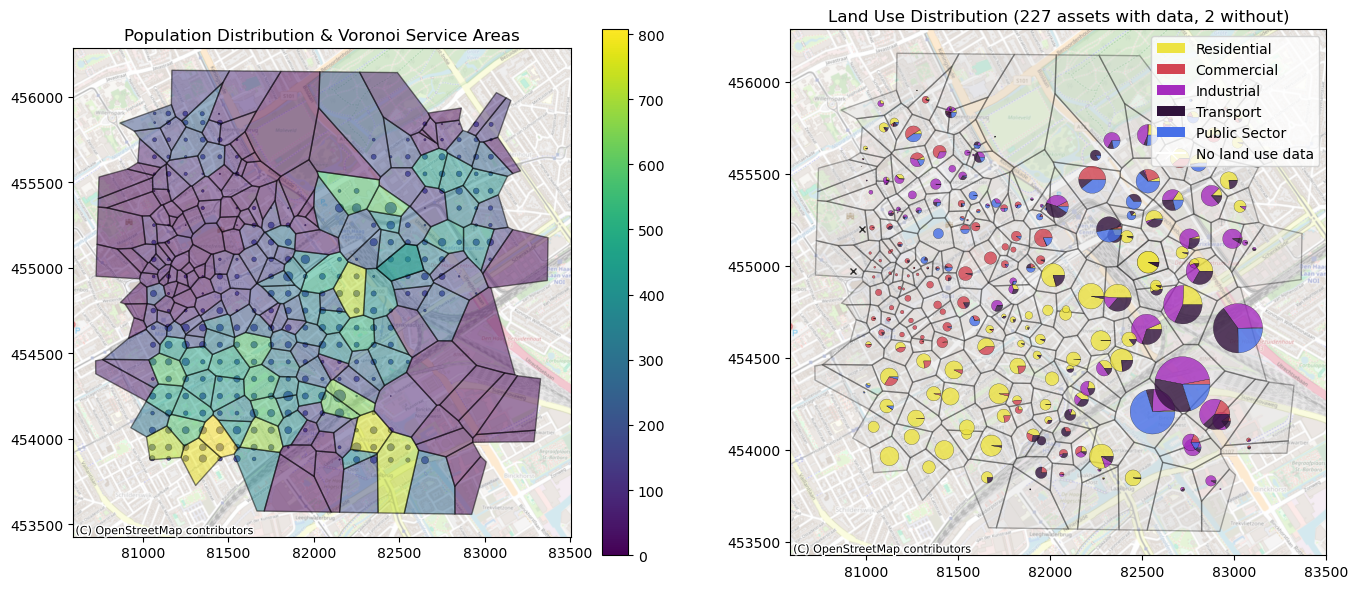

In [10]:
plot_population_and_landuse(
    population_above_0,
    sizes=population_above_0['aantal_inwoners'] / 10,
    voronoi_gdf=voronoi_gdf,
    gdf_assets=gdf_assets,
    asset_land_use_map=asset_land_use_map,
)

voronoi_gdf.to_file(config['interim_dir'] / 'voronoi_service_areas.geojson', driver='GeoJSON')
gdf_assets.to_file(config['interim_dir'] / 'assets_with_voronoi.geojson', driver='GeoJSON')

## Adaptation

There are multiple uncertainty sources that should be accounted for: 
- How many repair crews are there actually available? 
- What is the maintenance condition of the substations and how does that affect their probability of breakdown? 
- And perhaps most importantly, what adaptation measures can we adopt in this case?

As an operational measure, different repair schemes are considered, for example, prioritising repairs for substations that service the most population, or those that service the areas of highest monetary impacts. 

We identify two structural adaptation options:
- Elevating substations
- Increasing drainage for certain areas to reduce the inundation depth

In both cases, the depth of water that the adaptation measure reduces is subtracted from the affected assets. In the case of increasing drainage, the effect on both, substations and roads is considered.

We use the Exploratory Modelling Analysis (EMA) workbench for this process: https://github.com/quaquel/EMAworkbench

 Kwakkel, J. H. (2017). The Exploratory Modeling Workbench: An open source toolkit for exploratory modeling, scenario discovery, and (multi-objective) robust decision making. Environmental Modelling & Software, 96, 239–250. https://doi.org/10.1016/j.envsoft.2017.06.054



```{Important}
The 'simulate_asset_damage_recovery_access_breakdown_ema' function is a wrapper for the 'simulate_asset_damage_recovery_access_breakdown' function used in the single assessment run earlier. It is designed to be passed as the function keyword argument for the Model class of the EMA workbench as shown below.

For this cell, expect long runtimes for large number of scenarios.
```

In [11]:
ema_logging.log_to_stderr(ema_logging.INFO)

# Load caches
caches = load_simulation_caches(config['interim_dir'], config['hazard_dir'])
print(f"Loaded caches: {[k for k in caches.keys() if caches[k] is not None]}")

max_days = None
execution_id = int(time.time())

# Set up EMA model
model = Model('ElectricitySimulation', function=simulate_asset_damage_recovery_access_breakdown_ema)

model.uncertainties = [
    IntegerParameter('number_repair_crews', 1, 5),
    RealParameter('fragility_param_k', 5.0, 7.5)
]

keep_3d_vars = []  # No per-asset arrays
keep_2d_vars = ['flooded', 'operational', 'damage_ratio', 'repair_time']  # Aggregated

model.constants = [
    Constant('flood_threshold', 0.2),
    Constant('gdf_assets', gdf_assets),
    Constant('hazard_maps', hazard_maps[:max_days]),
    Constant('recovery_parameters', config['recovery_parameters']),
    Constant('root_dir', config['root_dir']),
    Constant('verbose', False),
    Constant('timestep_output', True),
    Constant('execution_id', execution_id),
    Constant('config', config),
    Constant('major_timestep', 24),
    # Cache parameters
    Constant('accessibility_cache', caches.get('accessibility_cache')),
    Constant('hazard_extraction_cache', caches.get('hazard_extraction_cache')),
    Constant('overlap_cache', caches.get('overlap_cache')),
    Constant('island_cache', caches.get('island_cache')),
    # Impact data
    Constant('asset_population_map', asset_population_map),
    Constant('asset_to_lu', asset_to_lu),
    # Dimensionality control 
    Constant('keep_3d_vars', []),  # 
    Constant('keep_2d_vars', ['flooded', 'operational', 'damage_ratio', 'repair_time']) 
]

# Build outcomes list
outcomes_list = []

# Add 3D outcomes (none in this case)
for var in keep_3d_vars:
    outcomes_list.append(TimeSeriesOutcome(var))

# Add 2D outcomes (aggregated across assets)
for var in keep_2d_vars:
    outcomes_list.append(TimeSeriesOutcome(var))

# Add mandatory 1D outcomes (always present)
outcomes_list.extend([
    TimeSeriesOutcome('timesteps'),
    # Population impact outcomes
    TimeSeriesOutcome('affected_population'),
    TimeSeriesOutcome('served_population'),
    TimeSeriesOutcome('affected_population_ratio'),
    # Monetary impacts
    TimeSeriesOutcome('monetary_impact_total'),
    TimeSeriesOutcome('monetary_impact_residential'),
    TimeSeriesOutcome('monetary_impact_commercial'),
    TimeSeriesOutcome('monetary_impact_industrial'),
    TimeSeriesOutcome('monetary_impact_transport'),
    TimeSeriesOutcome('monetary_impact_public_sector'),
])

model.outcomes = outcomes_list

# Set up policies
l1_pumping_area = root_dir / 'data' / 'test_samples' / 'adaptation' / 'l1_adapt_polygon.geojson'
l2_asset_barriers = root_dir / 'data' / 'test_samples' / 'adaptation' / 'l2_adapt_polygon.geojson'


policies = [
    Policy('population_impacts_policy', repair_crew_assignment_method='population impacts islands'),
    Policy('monetary_impacts_policy', repair_crew_assignment_method='monetary impacts islands'),    
    Policy('lowest_repair_time_islands_policy', repair_crew_assignment_method='lowest repair time islands'),
    Policy('highest_repair_time_islands_policy', repair_crew_assignment_method='highest repair time islands'),
    
    # Adaptation 
    Policy('baseline', 
           repair_crew_assignment_method='monetary impacts islands'),
    
    Policy('L1_area_pumping + monetary', 
           repair_crew_assignment_method='monetary impacts islands',
           l1_area_geojson=str(l1_pumping_area),
           l1_active_timesteps=list(range(24, 165))),
    
    Policy('L2_asset_protection + monetary',
           repair_crew_assignment_method='monetary impacts islands',
           l2_asset_geojson=str(l2_asset_barriers),
           l2_active_timesteps=list(range(0, 240))),
    
    Policy('L1_and_L2_combined + monetary',
           repair_crew_assignment_method='monetary impacts islands',
           l1_area_geojson=str(l1_pumping_area),
           l1_active_timesteps=list(range(24, 165)),
           l2_asset_geojson=str(l2_asset_barriers),
           l2_active_timesteps=list(range(0, 240))),
]

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(
        scenarios=50,
        policies=policies,
        uncertainty_sampling=Samplers.LHS
    )
    
experiments_df = pd.DataFrame(experiments)
print(f"\nCompleted all experiments with execution id {execution_id}. Total runs: {len(experiments)}")

[MainProcess/INFO] performing 50 scenarios * 8 policies * 1 model(s) = 400 experiments


Loading simulation caches...
No accessibility cache found at c:\repos\UC3\data\interim\interim_test_hazard_timesteps\accessibility_cache_test_hazard_timesteps.pkl
Loaded hazard extraction cache: 10 entries from c:\repos\UC3\data\interim\interim_test_hazard_timesteps\hazard_extraction_cache_test_hazard_timesteps.pkl
Loaded overlap cache: 9 entries from c:\repos\UC3\data\interim\interim_test_hazard_timesteps\overlap_cache_test_hazard_timesteps.pkl
Loaded island cache: 10 entries from c:\repos\UC3\data\interim\interim_test_hazard_timesteps\island_cache_test_hazard_timesteps.pkl
Loaded caches: ['accessibility_cache', 'hazard_extraction_cache', 'overlap_cache', 'island_cache']


 62%|█████████████████████████               | 250/400 [00:26<00:14, 10.15it/s]

Cache miss for island_assignment_EV0_ma_0.2_n245_ffb9075134a2efe7ad5cdcebb95eef31_L1f5bd4d04, computing islands on the fly...
Loading hazard graph from c:\repos\UC3\data\test_samples\static\output_graph\base_graph_hazard_editted.p
Saved island cache: 11 entries to c:\repos\UC3\data\interim\interim_test_hazard_timesteps\island_cache_test_hazard_timesteps.pkl
Successfully computed and cached islands for island_assignment_EV0_ma_0.2_n245_ffb9075134a2efe7ad5cdcebb95eef31_L1f5bd4d04
Cache miss for island_assignment_EV1_ma_0.2_n245_ffb9075134a2efe7ad5cdcebb95eef31_L1f5bd4d04, computing islands on the fly...
Loading hazard graph from c:\repos\UC3\data\test_samples\static\output_graph\base_graph_hazard_editted.p
Saved island cache: 12 entries to c:\repos\UC3\data\interim\interim_test_hazard_timesteps\island_cache_test_hazard_timesteps.pkl
Successfully computed and cached islands for island_assignment_EV1_ma_0.2_n245_ffb9075134a2efe7ad5cdcebb95eef31_L1f5bd4d04
Computing island lengths...
Saved 

100%|████████████████████████████████████████| 400/400 [00:45<00:00,  8.73it/s]
[MainProcess/INFO] experiments finished



Completed all experiments with execution id 1771513793. Total runs: 400


And then we visualise the results

In [12]:
experiments_df.sort_values(by=['policy', 'scenario'], inplace=True)
print(f"Sample of experiment DataFrame:")
experiments_df.sample(10).sort_index()

Sample of experiment DataFrame:


fragility_param_k  number_repair_crews scenario  \
0             5.735938                    2        0   
121           6.275224                    1       21   
130           5.011044                    4       30   
144           5.114600                    5       44   
177           5.782857                    2       27   
189           7.050600                    3       39   
247           5.165909                    2       47   
252           6.788225                    2        2   
275           6.746287                    4       25   
299           6.964824                    4       49   

                                 policy                  model  
0             population_impacts_policy  ElectricitySimulation  
121   lowest_repair_time_islands_policy  ElectricitySimulation  
130   lowest_repair_time_islands_policy  ElectricitySimulation  
144   lowest_repair_time_islands_policy  ElectricitySimulation  
177  highest_repair_time_islands_policy  ElectricitySimulation  
189  highest_repair_time_islands_policy  ElectricitySimulation  
247                            baseline  ElectricitySimulation  
252          L1_area_pumping + monetary  ElectricitySimulation  
275          L1_area_pumping + monetary  ElectricitySimulation  
299          L1_area_pumping + monetary  ElectricitySimulation

## Comparison of adaptation options

Here we can see the summary of results for the runs, and the effect each adaptation policy has on the outcomes.

In [13]:
available_outcomes = list(outcomes.keys())

# Categorize outcomes
asset_outcomes_3d = keep_3d_vars  
asset_outcomes_2d = keep_2d_vars  
population_outcomes = ['affected_population', 'served_population', 'affected_population_ratio']
monetary_outcomes = ['monetary_impact_total', 'monetary_impact_residential', 
                    'monetary_impact_commercial', 'monetary_impact_industrial',
                    'monetary_impact_transport', 'monetary_impact_public_sector']

# Select outcomes to plot
outcomes_to_show = []

# Add available asset outcomes (will be aggregated if 3D)
for outcome in asset_outcomes_3d + asset_outcomes_2d:
    if outcome in available_outcomes:
        outcomes_to_show.append(outcome)

# Add population outcomes (already 1D/2D)
for outcome in population_outcomes:
    if outcome in available_outcomes:
        outcomes_to_show.append(outcome)

# Add monetary outcomes (already 1D/2D, cumulative)
for outcome in monetary_outcomes:
    if outcome in available_outcomes:
        outcomes_to_show.append(outcome)

# Aggregate only what needs aggregation
aggregation_info = aggregate_outcomes(outcomes, outcomes_to_show)

print("\nAggregation summary:")
for key, info in aggregation_info.items():
    print(f"  {key}: {info}")



Aggregation summary:
  flooded: already 2D
  operational: already 2D
  damage_ratio: already 2D
  repair_time: already 2D
  affected_population: already 2D
  served_population: already 2D
  affected_population_ratio: already 2D
  monetary_impact_total: already 2D
  monetary_impact_residential: already 2D
  monetary_impact_commercial: already 2D
  monetary_impact_industrial: already 2D
  monetary_impact_transport: already 2D
  monetary_impact_public_sector: already 2D


And plot it using the lines function, part of the EMA workbench

To explore the different outputs, some grouping and filtering functionalities are prepared.

```{warning}
Monetary impacts are illustrative unless calculated with country-wide VOLL rates instead of sample data!
```

c:\repos\UC3\src\visualization.py:716: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return experiments_df[mask]
c:\repos\UC3\src\visualization.py:716: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return experiments_df[mask]


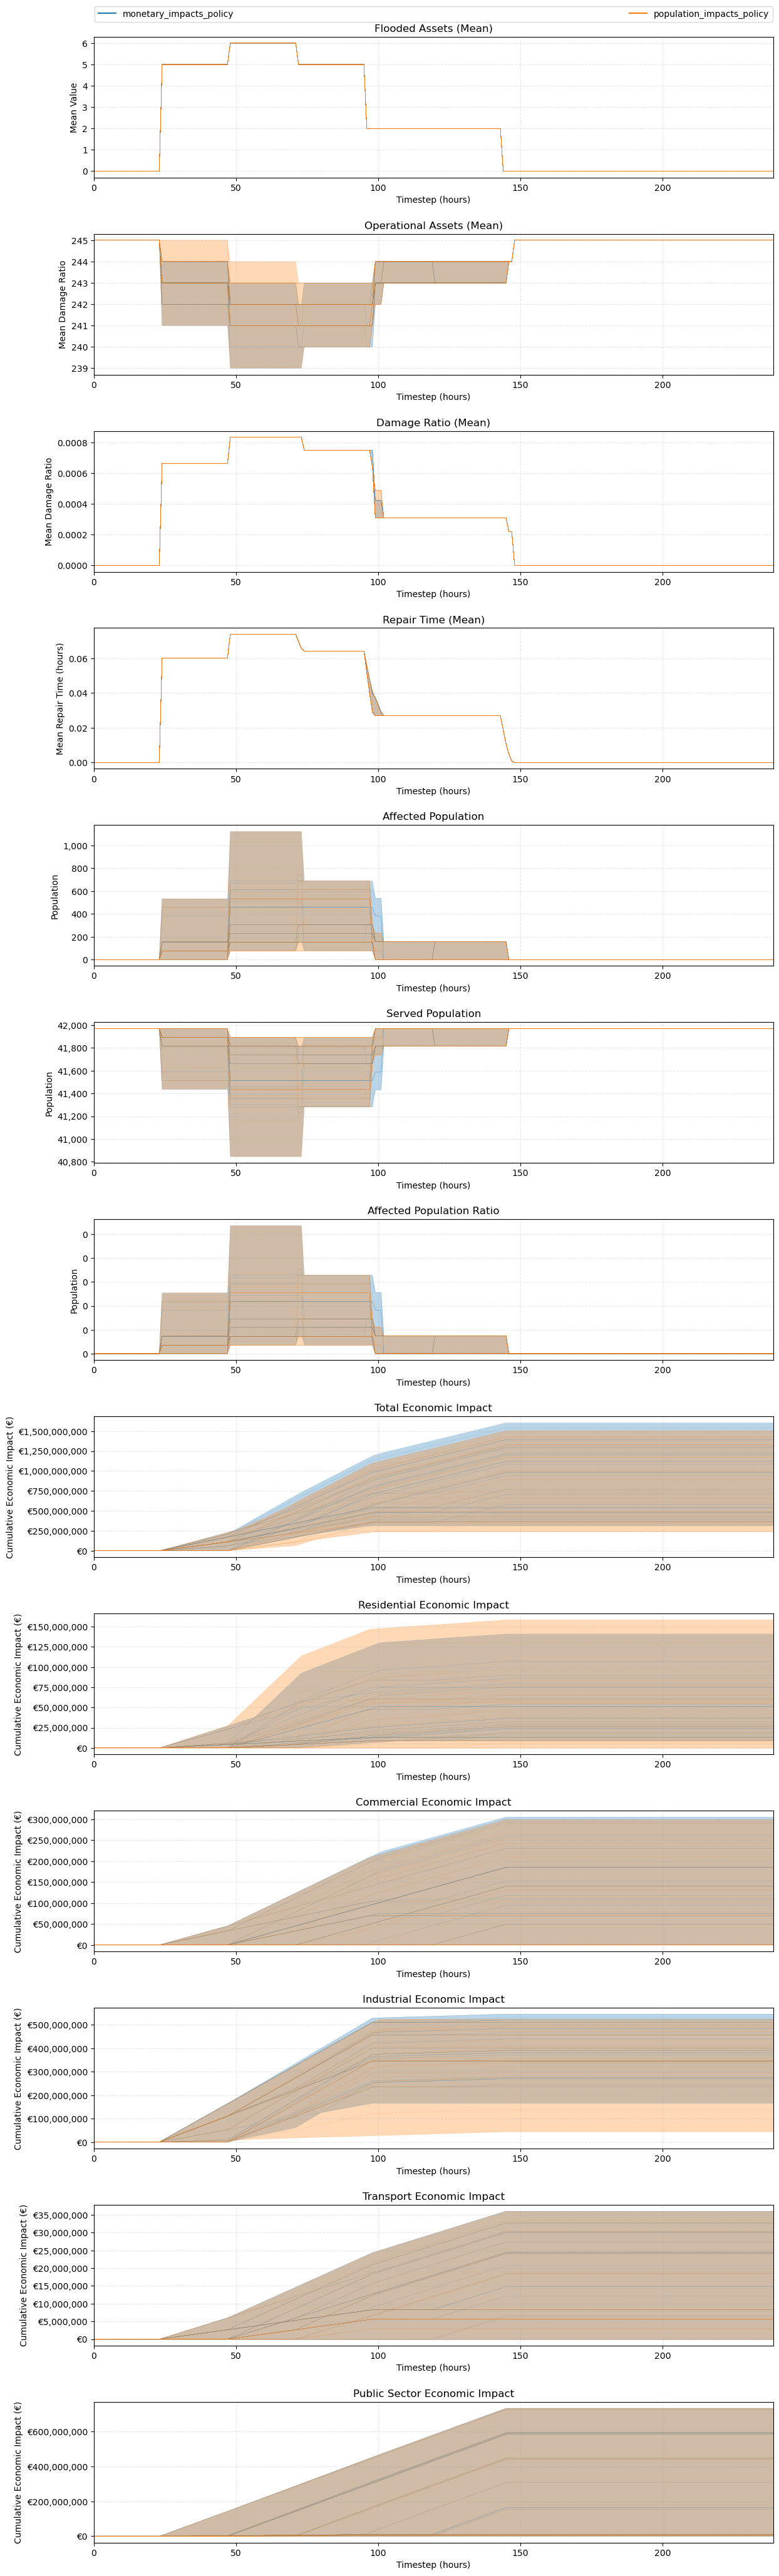



Plot summary:

Grouped by: policy
Number of bins: N/A

Outcomes plotted:
  • flooded                                  Asset (2D pre-aggregated)      2D (400 experiments x 240 timesteps)
  • operational                              Asset (2D pre-aggregated)      2D (400 experiments x 240 timesteps)
  • damage_ratio                             Asset (2D pre-aggregated)      2D (400 experiments x 240 timesteps)
  • repair_time                              Asset (2D pre-aggregated)      2D (400 experiments x 240 timesteps)
  • affected_population                      Population                     2D (400 experiments x 240 timesteps)
  • served_population                        Population                     2D (400 experiments x 240 timesteps)
  • affected_population_ratio                Population                     2D (400 experiments x 240 timesteps)
  • monetary_impact_total                    Monetary (cumulative)          2D (400 experiments x 240 timesteps)
  • monetary_impact_r

c:\repos\UC3\src\visualization.py:716: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return experiments_df[mask]
c:\repos\UC3\src\visualization.py:716: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return experiments_df[mask]


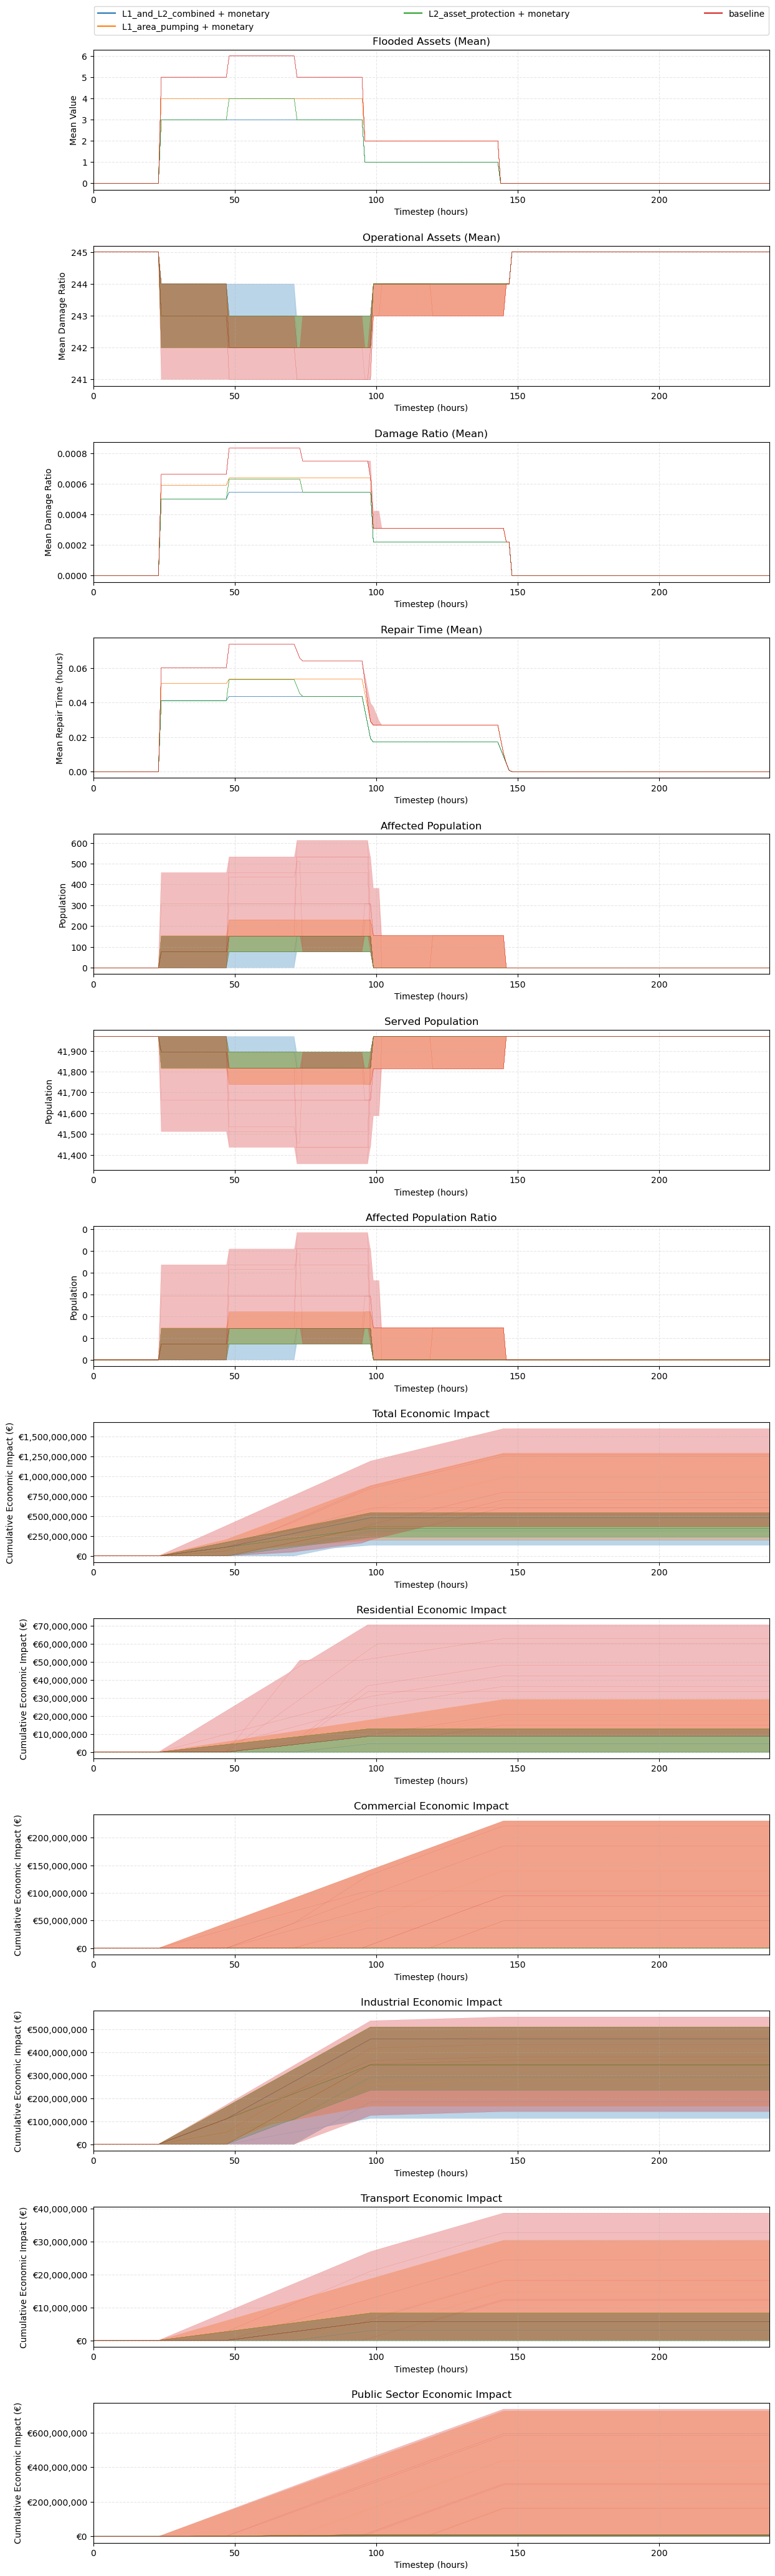



Plot summary:

Grouped by: policy
Number of bins: N/A

Outcomes plotted:
  • flooded                                  Asset (2D pre-aggregated)      2D (400 experiments x 240 timesteps)
  • operational                              Asset (2D pre-aggregated)      2D (400 experiments x 240 timesteps)
  • damage_ratio                             Asset (2D pre-aggregated)      2D (400 experiments x 240 timesteps)
  • repair_time                              Asset (2D pre-aggregated)      2D (400 experiments x 240 timesteps)
  • affected_population                      Population                     2D (400 experiments x 240 timesteps)
  • served_population                        Population                     2D (400 experiments x 240 timesteps)
  • affected_population_ratio                Population                     2D (400 experiments x 240 timesteps)
  • monetary_impact_total                    Monetary (cumulative)          2D (400 experiments x 240 timesteps)
  • monetary_impact_r

In [14]:
# Configure grouping
group_by = "policy"
# Alternative groupings (uncomment to use):

# group_by = "number_repair_crews"
# bin_ranges = [(1, 1),(5, 5)]
# bin_ranges = create_bins(1, 4, bin_size=1)

# group_by = "fragility_param_k"
# bin_ranges = create_float_bins(5.0, 7.5, 0.5)

# Configure filters
var_val = {'number_repair_crews': (2,4), # Example: filter for 2 to 4 repair crews
           'policy': ['population_impacts_policy', 'monetary_impacts_policy']}  # Example: filter for specific policies

# Filter experiments DataFrame for the desired value
experiments_sample = sample_experiments(var_val, experiments_df)
sample_indices = experiments_sample.index.values

# Filter outcomes for these indices
outcomes_for_sample = {k: v[sample_indices] for k, v in outcomes.items()}

plot_grouped_outcomes(
    group_by=group_by,
    experiments_df=experiments_df,
    outcomes=outcomes,
    outcomes_to_show=outcomes_to_show,
    var_val=var_val,
    bin_ranges=None,
    monetary_outcomes=monetary_outcomes,
    population_outcomes=population_outcomes,
    asset_outcomes_3d=asset_outcomes_3d,
    asset_outcomes_2d=asset_outcomes_2d,
)

# Configure filters for adaptation policies given a number of repair crews
var_val = {'number_repair_crews': (3,3), # Example: filter for 3 repair crews
           'policy': ['baseline', 'L1_area_pumping + monetary', 'L2_asset_protection + monetary', 'L1_and_L2_combined + monetary']}  # Example: filter for specific policies

# Filter experiments DataFrame for the desired value
experiments_sample = sample_experiments(var_val, experiments_df)
sample_indices = experiments_sample.index.values

# Filter outcomes for these indices
outcomes_for_sample = {k: v[sample_indices] for k, v in outcomes.items()}

plot_grouped_outcomes(
    group_by=group_by,
    experiments_df=experiments_df,
    outcomes=outcomes,
    outcomes_to_show=outcomes_to_show,
    var_val=var_val,
    bin_ranges=None,
    monetary_outcomes=monetary_outcomes,
    population_outcomes=population_outcomes,
    asset_outcomes_3d=asset_outcomes_3d,
    asset_outcomes_2d=asset_outcomes_2d,
)

# Run comparison
experiments_df = pd.DataFrame(experiments)
compare_adaptation_policies(experiments_df, outcomes)

## References

- FEMA. Multi-Hazard Loss Estimation Methodology, Flood Model: Hazus-MH MR4 Technical Manual, 2009th ed.; FEMA: Washington, DC, USA, 2009.
 
- Movahednia, M., Kargarian, A., Ozdemir, C. E., & Hagen, S. C. (2022). Power Grid Resilience Enhancement via Protecting Electrical Substations Against Flood Hazards: A Stochastic Framework. IEEE Transactions on Industrial Informatics, 18(3), 2132–2143. https://doi.org/10.1109/TII.2021.3100079

- Sánchez-Muñoz, D., Domínguez-García, J. L., Martínez-Gomariz, E., Russo, B., Stevens, J., & Pardo, M. (2020). Electrical Grid Risk Assessment Against Flooding in Barcelona and Bristol Cities. Sustainability, 12(4), 1527. https://doi.org/10.3390/su12041527